# Projeto Machine Learning 2 - Decision Tree

In [1]:
#Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn.metrics import mean_squared_error, r2_score,confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score


from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV


from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Carregando dataset
df=pd.read_parquet('spotify_songs.parquet')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32833 entries, 6f807x0ima9a1j3VPbc7VN to 29zWqhca3zt5NsckZqDf6c
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_name                32828 non-null  object 
 1   track_artist              32828 non-null  object 
 2   track_popularity          32833 non-null  int64  
 3   track_album_id            32833 non-null  object 
 4   track_album_name          32828 non-null  object 
 5   track_album_release_date  32833 non-null  object 
 6   playlist_name             32833 non-null  object 
 7   playlist_id               32833 non-null  object 
 8   playlist_genre            32833 non-null  object 
 9   playlist_subgenre         32833 non-null  object 
 10  danceability              32833 non-null  float64
 11  energy                    32833 non-null  float64
 12  key                       32833 non-null  int64  
 13  loudness                  32

## Limpeza do dataset

Foram removidas as colunas `track_album_id` ,`track_album_name`,`track_album_release_date`,`playlist_name` e `playlist_id`.

In [4]:
#removendo colunas 
df = df.drop(columns=['track_album_id','track_album_name','track_album_release_date','playlist_name','playlist_id'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32833 entries, 6f807x0ima9a1j3VPbc7VN to 29zWqhca3zt5NsckZqDf6c
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_name         32828 non-null  object 
 1   track_artist       32828 non-null  object 
 2   track_popularity   32833 non-null  int64  
 3   playlist_genre     32833 non-null  object 
 4   playlist_subgenre  32833 non-null  object 
 5   danceability       32833 non-null  float64
 6   energy             32833 non-null  float64
 7   key                32833 non-null  int64  
 8   loudness           32833 non-null  float64
 9   mode               32833 non-null  int64  
 10  speechiness        32833 non-null  float64
 11  acousticness       32833 non-null  float64
 12  instrumentalness   32833 non-null  float64
 13  liveness           32833 non-null  float64
 14  valence            32833 non-null  float64
 15  tempo              32833 non-null  fl

Vamos avaliar os possível valores nulos do dataset.

In [6]:
df.isnull().sum()

track_name           5
track_artist         5
track_popularity     0
playlist_genre       0
playlist_subgenre    0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
dtype: int64

In [7]:
df[df['track_name'].isnull()][['track_name','track_artist','track_popularity']]

,track_name,track_artist,track_popularity
track_id,,,
69gRFGOWY9OMpFJgFol1u0,None,None,0
5cjecvX0CmC9gK0Laf5EMQ,None,None,0
5TTzhRSWQS4Yu8xTgAuq6D,None,None,0
3VKFip3OdAvv4OfNTgFWeQ,None,None,0
69gRFGOWY9OMpFJgFol1u0,None,None,0


Verificamos que apenas 5 entradas não tem nome da música ou do artista. Essas 5 faixar também estão com a popularidade zerada. 
Vamos remover essas 5 entradas do dataset

In [8]:
df = df.dropna(subset=['track_name'])

In [9]:
df.isnull().sum()

track_name           0
track_artist         0
track_popularity     0
playlist_genre       0
playlist_subgenre    0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
dtype: int64

# Transformando variáveis catégoricas em dummy
Como modelo a ser utilizado (árvore de decisão) aceita apenas variaveis numéricas, vamos transformar as colunas `playlist_genre` e `playlist_subgenre` em dummies.

In [10]:
# Usando get_dummies para converter as variável categórica em colunas indicadoras
df = pd.get_dummies(df, columns=['playlist_genre','playlist_subgenre','key','mode'], prefix=['genre', 'subgenre','key','mode'])

In [11]:
df.head()

,track_name,track_artist,track_popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,...,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_0,mode_1
track_id,,,,,,,,,,,,,,,,,,,,,
6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,0.748,0.916,-2.634,0.0583,0.1020,0.000000,0.0653,...,False,False,True,False,False,False,False,False,False,True
0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,0.726,0.815,-4.969,0.0373,0.0724,0.004210,0.3570,...,False,False,False,False,False,False,False,True,False,True
1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,0.675,0.931,-3.432,0.0742,0.0794,0.000023,0.1100,...,False,False,False,False,False,False,False,False,True,False
75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,0.718,0.930,-3.778,0.1020,0.0287,0.000009,0.2040,...,False,False,False,True,False,False,False,False,False,True
1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,0.650,0.833,-4.672,0.0359,0.0803,0.000000,0.0833,...,False,False,False,False,False,False,False,False,False,True


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32828 entries, 6f807x0ima9a1j3VPbc7VN to 29zWqhca3zt5NsckZqDf6c
Data columns (total 57 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   track_name                          32828 non-null  object 
 1   track_artist                        32828 non-null  object 
 2   track_popularity                    32828 non-null  int64  
 3   danceability                        32828 non-null  float64
 4   energy                              32828 non-null  float64
 5   loudness                            32828 non-null  float64
 6   speechiness                         32828 non-null  float64
 7   acousticness                        32828 non-null  float64
 8   instrumentalness                    32828 non-null  float64
 9   liveness                            32828 non-null  float64
 10  valence                             32828 non-null  float64
 11  tempo   

# Separação das categorias

In [13]:
# Converting 'track_popularity' to categorical labels
def classify_popularity(popularity):
    if popularity <= 20:
        return 0
    elif popularity <= 40:
        return 1
    elif popularity <= 60:
        return 2
    else:
        return 3

df['popularity_class'] = df['track_popularity'].apply(classify_popularity)

In [14]:
#df['quartis'] = pd.qcut(df['track_popularity'], q=4, labels=False)

In [15]:
#df['quartis'].plot(kind='hist', bins=4)

# Estabelecendo X,y

In [16]:
X = df.drop(columns=['track_name','track_artist','track_popularity','popularity_class'])
y = df['track_popularity']

# Treinando Regressor por arvore de decisão (sem boost)

Erro Quadrático Médio (MSE): 805.41
Coeficiente de Determinação (R²): -0.29


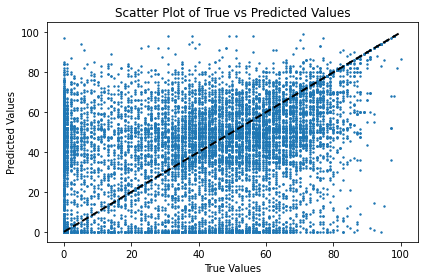

In [17]:
# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

df_r2 = []
varlist=[1]

for var in varlist:

    # Criando o pipeline com MinMaxScaler e AdaBoostRegressor
    pipeline = Pipeline([
        ('regressor', DecisionTreeRegressor(max_depth=23))
    ])

    # Treinando o modelo usando o pipeline
    pipeline.fit(X_train, y_train)


    # Fazendo previsões no conjunto de teste
    y_pred = pipeline.predict(X_test)
    #clipar para garantir que os valores estejam entre 0 e 100
    y_pred = np.clip(y_pred, 0, 100)

    # Avaliando o desempenho do modelo
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Imprima as métricas de avaliação
    print(f'Erro Quadrático Médio (MSE): {mse:.2f}')
    print(f'Coeficiente de Determinação (R²): {r2:.2f}')
    df_r2.append(r2)

#scaterplot
plt.scatter(y_test, y_pred,s=2)
plt.plot([0, 100], [0, 100], color='black', linestyle='--', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of True vs Predicted Values')
plt.tight_layout()
plt.show()


# Treinando Regressor por arvore de decisão (XGBoost)

Erro Quadrático Médio (MSE): 478.47
Coeficiente de Determinação (R²): 0.23


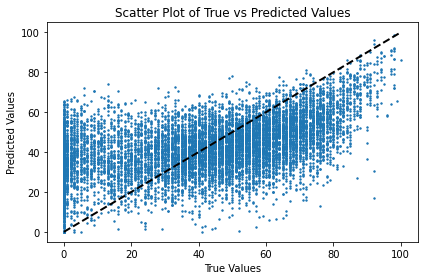

In [18]:
# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

df_r2 = []
varlist = [1]

for var in varlist:


    # Criando o pipeline com MinMaxScaler e AdaBoostRegressor
    pipeline_xgb = Pipeline([
        ('adaboost', XGBRegressor(n_estimators=370, learning_rate=0.13, random_state=42))
    ])

    # Treinando o modelo usando o pipeline
    pipeline_xgb.fit(X_train, y_train)


    # Fazendo previsões no conjunto de teste
    y_pred = pipeline_xgb.predict(X_test)
    #clipar para garantir que os valores estejam entre 0 e 100
    y_pred = np.clip(y_pred, 0, 100)

    # Avaliando o desempenho do modelo
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Imprima as métricas de avaliação
    #print(f'Erro Quadrático Médio (MSE): {mse:.2f}')
    #print(f'Coeficiente de Determinação (R²): {r2:.2f}')
    df_r2.append(r2)

print(f'Erro Quadrático Médio (MSE): {mse:.2f}')
print(f'Coeficiente de Determinação (R²): {r2:.2f}')    

    

plt.scatter(y_test, y_pred,s=2)
plt.plot([0, 100], [0, 100], color='black', linestyle='--', linewidth=2)


plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of True vs Predicted Values')
plt.tight_layout()
plt.show()



#set_config(display="diagram")
#pipeline

# Treinando Regressor por arvore de decisão (adaboost)

Erro Quadrático Médio (MSE): 463.61
Coeficiente de Determinação (R²): 0.26


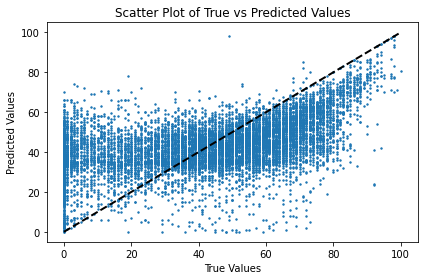

In [19]:
# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

df_r2 = []
varlist=[1]

for var in varlist:
    # Criando um regressor 
    base_regressor = DecisionTreeRegressor(max_depth=23)  #

    # Criando o pipeline com MinMaxScaler e AdaBoostRegressor
    pipeline_ada = Pipeline([
        ('adaboost', AdaBoostRegressor(base_regressor, n_estimators=200, learning_rate=0.21, random_state=42))
    ])

    # Treinando o modelo usando o pipeline
    pipeline_ada.fit(X_train, y_train)


    # Fazendo previsões no conjunto de teste
    y_pred = pipeline_ada.predict(X_test)
    #clipar para garantir que os valores estejam entre 0 e 100
    y_pred = np.clip(y_pred, 0, 100)

    # Avaliando o desempenho do modelo
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Imprima as métricas de avaliação
    print(f'Erro Quadrático Médio (MSE): {mse:.2f}')
    print(f'Coeficiente de Determinação (R²): {r2:.2f}')
    df_r2.append(r2)

#scaterplot
plt.scatter(y_test, y_pred,s=2)
plt.plot([0, 100], [0, 100], color='black', linestyle='--', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of True vs Predicted Values')
plt.tight_layout()
plt.show()



#set_config(display="diagram")
#pipeline

Comparando os dos métodos de boost, escolhemos pelo Adaboost pel

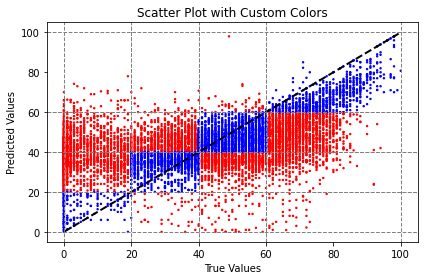

In [20]:
import matplotlib.pyplot as plt
import numpy as np


# Defina o intervalo
intervalo1_x = (0, 20)
intervalo1_y = (0, 20)

intervalo2_x = (20, 40)
intervalo2_y = (20, 40)

intervalo3_x = (40, 60)
intervalo3_y = (40, 60)

intervalo4_x = (60, 100)
intervalo4_y = (60, 100)

# Crie uma lista de cores com base nos intervalos
cores = np.where(
    ((y_test >= intervalo1_x[0]) & (y_test <= intervalo1_x[1]) &
    (y_pred >= intervalo1_y[0]) & (y_pred <= intervalo1_y[1])) |
    ((y_test >= intervalo2_x[0]) & (y_test <= intervalo2_x[1]) &
    (y_pred >= intervalo2_y[0]) & (y_pred <= intervalo2_y[1])) |
    ((y_test >= intervalo3_x[0]) & (y_test <= intervalo3_x[1]) &
    (y_pred >= intervalo3_y[0]) & (y_pred <= intervalo3_y[1])) |
    ((y_test >= intervalo4_x[0]) & (y_test <= intervalo4_x[1]) &
    (y_pred >= intervalo4_y[0]) & (y_pred <= intervalo4_y[1])),
    'blue',  # Cor para pontos dentro do intervalo
    'red'    # Cor para pontos fora do intervalo
)

# Crie o gráfico de dispersão usando as cores
plt.scatter(y_test, y_pred, c=cores, s=2)
plt.plot([0, 100], [0, 100], color='black', linestyle='--', linewidth=2)

# Adicione linhas para destacar o intervalo
plt.axvline(intervalo1_x[0], color='gray', linestyle='--', linewidth=1)
plt.axvline(intervalo1_x[1], color='gray', linestyle='--', linewidth=1)
plt.axhline(intervalo1_y[0], color='gray', linestyle='--', linewidth=1)
plt.axhline(intervalo1_y[1], color='gray', linestyle='--', linewidth=1)

plt.axvline(intervalo2_x[0], color='gray', linestyle='--', linewidth=1)
plt.axvline(intervalo2_x[1], color='gray', linestyle='--', linewidth=1)
plt.axhline(intervalo2_y[0], color='gray', linestyle='--', linewidth=1)
plt.axhline(intervalo2_y[1], color='gray', linestyle='--', linewidth=1)

plt.axvline(intervalo3_x[0], color='gray', linestyle='--', linewidth=1)
plt.axvline(intervalo3_x[1], color='gray', linestyle='--', linewidth=1)
plt.axhline(intervalo3_y[0], color='gray', linestyle='--', linewidth=1)
plt.axhline(intervalo3_y[1], color='gray', linestyle='--', linewidth=1)

plt.axvline(intervalo4_x[0], color='gray', linestyle='--', linewidth=1)
plt.axvline(intervalo4_x[1], color='gray', linestyle='--', linewidth=1)
plt.axhline(intervalo4_y[0], color='gray', linestyle='--', linewidth=1)
plt.axhline(intervalo4_y[1], color='gray', linestyle='--', linewidth=1)


plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot with Custom Colors')
plt.tight_layout()
plt.show()


In [21]:
#Criando coluna com os valores preditos
y_predito = pipeline.predict(X)
#clipar para garantir que os valores estejam entre 0 e 100
y_predito = np.clip(y_predito, 0, 100)
#popular no dataset original
df['predicao']=y_predito

#classe predita
df['pred_class'] = df['predicao'].apply(classify_popularity)

Acurácia: 0.6743
Precisão: 0.6923
Recall: 0.6743
F1-score: 0.6769


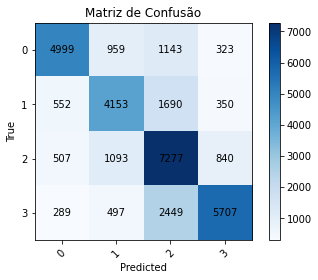

In [22]:
# Calcula a acurácia
accuracy = accuracy_score(df['popularity_class'], df['pred_class'])

# Calcula a precisão
precision = precision_score(df['popularity_class'], df['pred_class'], average='weighted')  # 'weighted' para lidar com classes desbalanceadas

# Calcula o recall
recall = recall_score(df['popularity_class'], df['pred_class'], average='weighted')  # 'weighted' para lidar com classes desbalanceadas

# Calcula o F1-score
f1 = f1_score(df['popularity_class'], df['pred_class'], average='weighted')  # 'weighted' para lidar com classes desbalanceadas

# Imprime as métricas
print(f'Acurácia: {accuracy:.4f}')
print(f'Precisão: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

# Gere a matriz de confusão
cm = confusion_matrix(df['popularity_class'], df['pred_class'])

# Define rótulos para os eixos
classes = np.unique(df['popularity_class'])
tick_marks = np.arange(len(classes))

# Plota a matriz de confusão
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Adicione rótulos aos eixos
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted')
plt.ylabel('True')

# Adicione valores nas células
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='k')

plt.title('Matriz de Confusão')
plt.colorbar()

# Exiba a plotagem
plt.show()




# Regressão baseado nas classes

In [23]:
X = df.drop(columns=['track_name','track_artist','track_popularity','popularity_class','pred_class','predicao'])
y = df['popularity_class'].astype(float)

In [24]:
# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

df_r2 = []
varlist=[1]

for var in varlist:
    # Criando um regressor 
    base_regressor = DecisionTreeRegressor(max_depth=23)  #

    # Criando o pipeline com MinMaxScaler e AdaBoostRegressor
    pipeline_ada = Pipeline([
        ('adaboost', AdaBoostRegressor(base_regressor, n_estimators=200, learning_rate=0.21, random_state=42))
    ])

    # Treinando o modelo usando o pipeline
    pipeline_ada.fit(X_train, y_train)
    
    # Fazendo previsões no conjunto de teste
    y_pred = pipeline_ada.predict(X_test)
    
    # Clipar para garantir que os valores estejam entre 0 e 3
    y_pred = np.clip(y_pred, 0, 3)
    
    # Arredondar para os inteiros mais próximos
    y_pred = np.round(y_pred).astype(int)


    # Avaliando o desempenho do modelo
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Imprima as métricas de avaliação
    print(f'Erro Quadrático Médio (MSE): {mse:.2f}')
    print(f'Coeficiente de Determinação (R²): {r2:.2f}')
    df_r2.append(r2)


Erro Quadrático Médio (MSE): 1.06
Coeficiente de Determinação (R²): 0.14


Precisão (Precision): 0.80
Revocação (Recall): 0.73
F1 Score: 0.73
Acurácia (Accuracy): 0.73


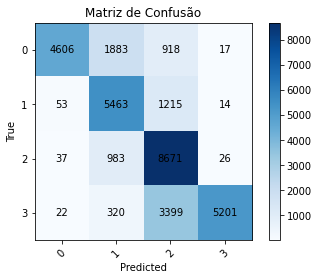

In [25]:
# Fazendo previsões no conjunto de teste
predicao = pipeline_ada.predict(X)
    
# Clipar para garantir que os valores estejam entre 0 e 3
predicao = np.clip(predicao, 0, 3)
    
# Arredondar para os inteiros mais próximos
predicao = np.round(predicao).astype(int)

# Calcular métricas
precision = precision_score(df['popularity_class'], predicao, average='weighted')
recall = recall_score(df['popularity_class'], predicao, average='weighted')
f1 = f1_score(df['popularity_class'], predicao, average='weighted')
accuracy = accuracy_score(df['popularity_class'], predicao)

# Imprimir as métricas
print(f'Precisão (Precision): {precision:.2f}')
print(f'Revocação (Recall): {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Acurácia (Accuracy): {accuracy:.2f}')


# Gere a matriz de confusão
cm = confusion_matrix(df['popularity_class'], predicao)

# Define rótulos para os eixos
classes = np.unique(df['popularity_class'])
tick_marks = np.arange(len(classes))

# Plota a matriz de confusão
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Adicione rótulos aos eixos
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted')
plt.ylabel('True')

# Adicione valores nas células
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='k')

plt.title('Matriz de Confusão')
plt.colorbar()

# Exiba a plotagem
plt.show()

# Classificação baseado nas classes

In [26]:
# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

df_r2 = []
varlist=[1]

for var in varlist:
    # Criando um regressor 
    base_regressor = DecisionTreeClassifier(max_depth=23)  #

    # Criando o pipeline com MinMaxScaler e AdaBoostRegressor
    pipeline_ada = Pipeline([
        ('adaboost', AdaBoostRegressor(base_regressor, n_estimators=200, learning_rate=0.21, random_state=42))
    ])

    # Treinando o modelo usando o pipeline
    pipeline_ada.fit(X_train, y_train)


    # Fazendo previsões no conjunto de teste
    y_pred = pipeline_ada.predict(X_test)
    #clipar para garantir que os valores estejam entre 0 e 100
    #y_pred = np.clip(y_pred, 0, 100)
    

Accuracy: 0.40
Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.11      0.19      2227
         1.0       0.30      0.46      0.37      2024
         2.0       0.37      0.66      0.47      2915
         3.0       0.79      0.32      0.45      2683

    accuracy                           0.40      9849
   macro avg       0.52      0.39      0.37      9849
weighted avg       0.52      0.40      0.38      9849




Precisão (Precision): 0.80
Revocação (Recall): 0.73
F1 Score: 0.73
Acurácia (Accuracy): 0.73


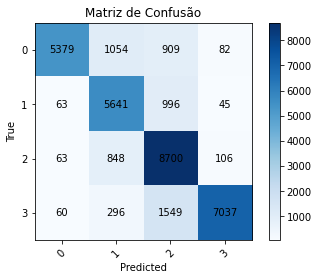

In [27]:
previsao = pipeline_ada.predict(X)

# Calcular métricas
precision = precision_score(df['popularity_class'], predicao, average='weighted')
recall = recall_score(df['popularity_class'], predicao, average='weighted')
f1 = f1_score(df['popularity_class'], predicao, average='weighted')
accuracy = accuracy_score(df['popularity_class'], predicao)

# Imprimir as métricas
print(f'Precisão (Precision): {precision:.2f}')
print(f'Revocação (Recall): {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Acurácia (Accuracy): {accuracy:.2f}')

# Gere a matriz de confusão
cm = confusion_matrix(df['popularity_class'], previsao)

# Define rótulos para os eixos
classes = np.unique(df['popularity_class'])
tick_marks = np.arange(len(classes))

# Plota a matriz de confusão
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Adicione rótulos aos eixos
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted')
plt.ylabel('True')

# Adicione valores nas células
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='k')

plt.title('Matriz de Confusão')
plt.colorbar()

# Exiba a plotagem
plt.show()